In [19]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import label
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


def pipeline(image_path, num_clasters=4):
    img = Image.open(image_path).convert('L') # grayscale
    data = np.array(img)
    # znajdz piksele czarne (wartosc < 200)
    y_raw, x_raw = np.where(data < 200)
    y_raw = data.shape[0] - y_raw
    X_pixels = np.column_stack((x_raw, y_raw))

    binary_mask = data < 200
    labeled_array, num_features = label(binary_mask)

    # wyciagamy srodki kropek
    kmeans_pixels = KMeans(n_clusters=num_features, n_init=10, random_state=42)
    kmeans_pixels.fit(X_pixels)
    X_points = kmeans_pixels.cluster_centers_


    # kmeans
    kmeans_final = KMeans(n_clusters=num_clasters, n_init=10, random_state=42) # zafixowane klastry
    labels_final = kmeans_final.fit_predict(X_points)
    fig, ax = plt.subplots()
    ax.scatter(X_points[:, 0], X_points[:, 1], c=labels_final, cmap='viridis', s=30, edgecolors='black')
    ax.set_title("Wynik K-Means: 4 klastry")
    ax.set_aspect('equal')
    plt.show()

    # dbscan
    def best_eps(X_points, k=4):
        neigh = NearestNeighbors(n_neighbors=k)
        neigh.fit(X_points)
        distances, _ = neigh.kneighbors(X_points)
        d = np.sort(distances[:, -1])
        # heurystyka: największy skok
        diffs = np.diff(d)
        idx = np.argmax(diffs)
        return d[idx]

    dbscan = DBSCAN(eps=best_eps(X_points), min_samples=4)
    labels_dbscan = dbscan.fit_predict(X_points)
    fig, ax = plt.subplots()
    ax.scatter(X_points[:, 0], X_points[:, 1], c=labels_dbscan, cmap='viridis', s=30, edgecolors='black')
    ax.set_title(f"Wynik DBSCAN: {len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)} klastrów")
    ax.set_aspect('equal')
    plt.show()

    # hierarchical clustering
    def best_cut(Z, X_points, distances):
        best = None
        best_score = -1
        for d in distances:
            labels = fcluster(Z, d, criterion='distance')
            if len(set(labels)) < 2: continue
            score = silhouette_score(X_points, labels)
            if score > best_score:
                best = d
                best_score = score
        return best

    Z = linkage(X_points, method='ward')
    # max_d = 750  # odległość cięcia dendrogramu
    max_d = best_cut(Z, X_points, np.linspace(10, 200, 20))
    # labels_hier = fcluster(Z, max_d, criterion='distance')
    labels_hier = fcluster(Z, num_clasters, criterion='maxclust')   # na sztywno podana liczba klastrów
    fig, ax = plt.subplots()
    ax.scatter(X_points[:, 0], X_points[:, 1], c=labels_hier, cmap='viridis', s=30, edgecolors='black')
    ax.set_title(f"Wynik Hierarchical Clustering: {len(set(labels_hier))} klastrów")
    ax.set_aspect('equal')
    plt.show()

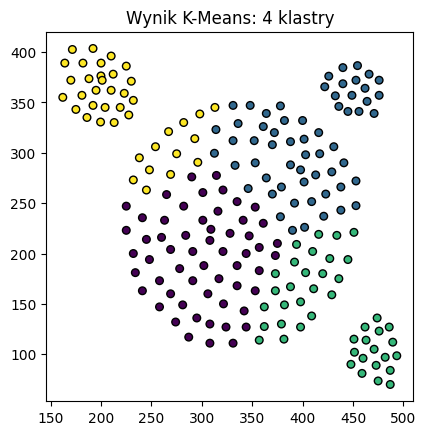

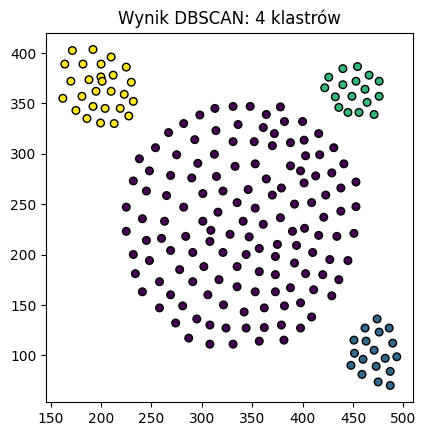

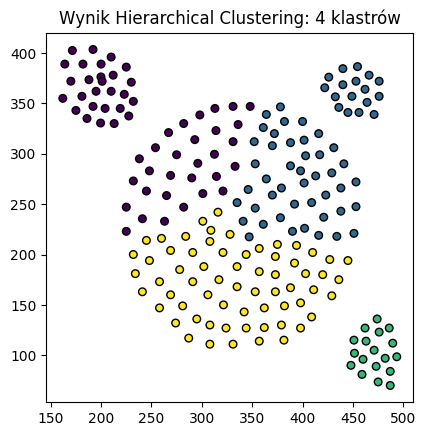

In [20]:
pipeline("fig1.png")

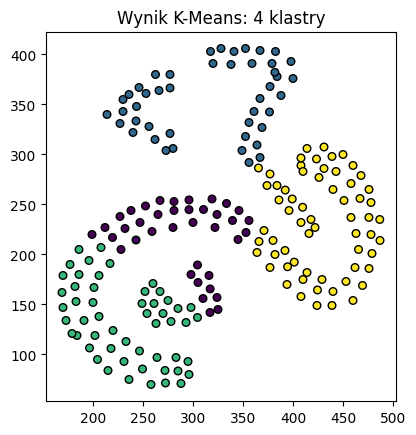

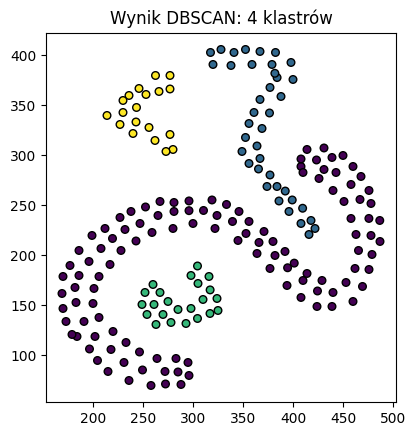

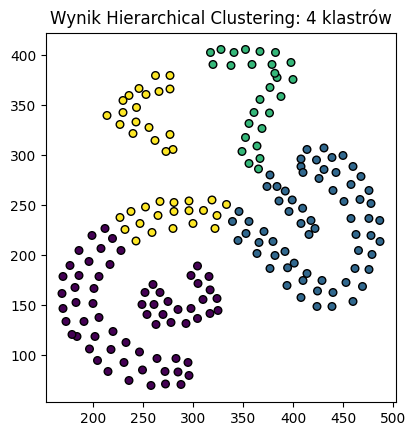

In [21]:
pipeline("fig2.png")

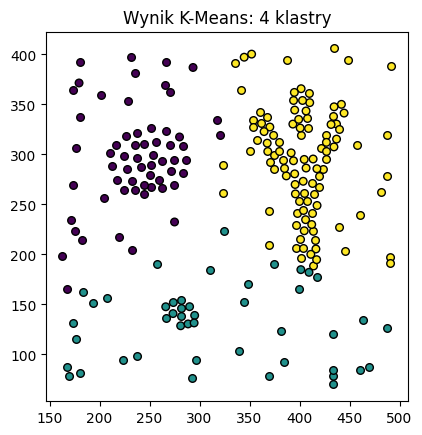

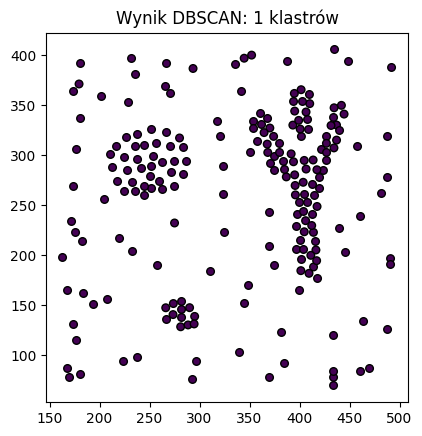

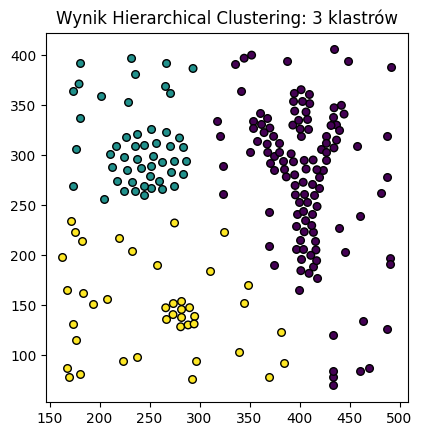

In [22]:
pipeline("fig3.png", num_clasters=3)

##  we see that dbscan for fig3 gives 1 cluster, so we will try different eps values

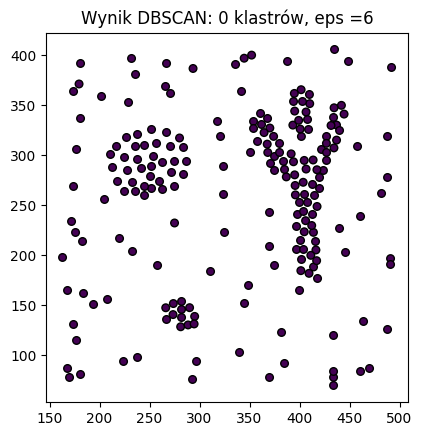

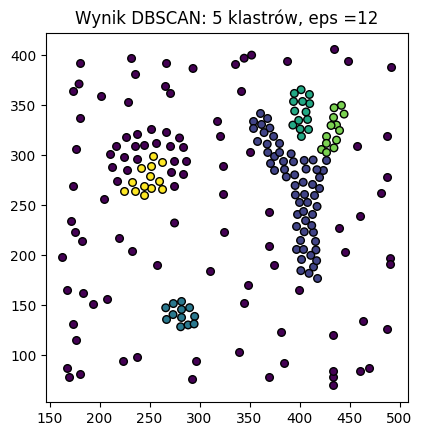

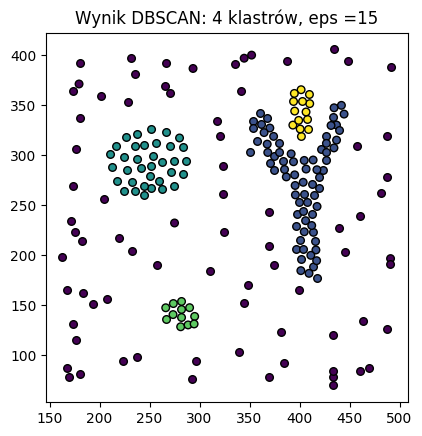

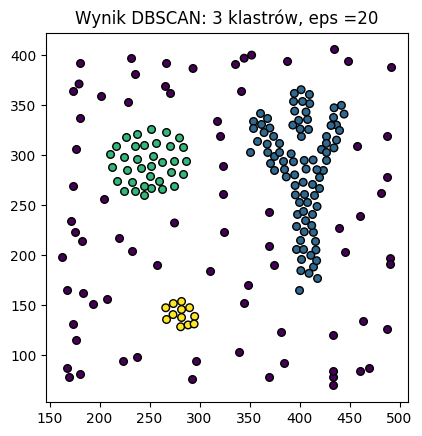

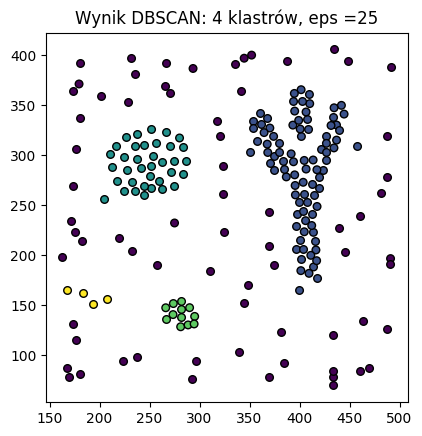

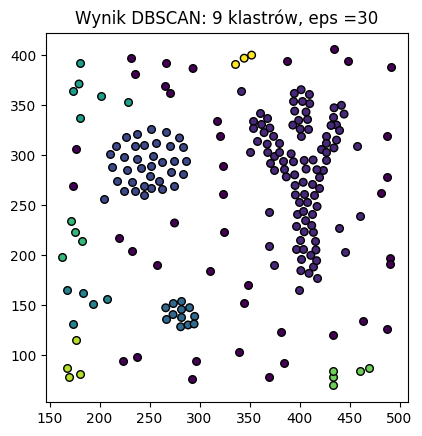

In [30]:
def pipeline_dbscan_only(image_path):
    img = Image.open(image_path).convert('L') # grayscale
    data = np.array(img)
    # znajdz piksele czarne (wartosc < 200)
    y_raw, x_raw = np.where(data < 200)
    y_raw = data.shape[0] - y_raw
    X_pixels = np.column_stack((x_raw, y_raw))

    binary_mask = data < 200
    labeled_array, num_features = label(binary_mask)

    # wyciagamy srodki kropek
    kmeans_pixels = KMeans(n_clusters=num_features, n_init=10, random_state=42)
    kmeans_pixels.fit(X_pixels)
    X_points = kmeans_pixels.cluster_centers_

    for eps in [6, 12,15,20, 25, 30]:
        dbscan = DBSCAN(eps=eps, min_samples=4)
        labels_dbscan = dbscan.fit_predict(X_points)
        fig, ax = plt.subplots()
        ax.scatter(X_points[:, 0], X_points[:, 1], c=labels_dbscan, cmap='viridis', s=30, edgecolors='black')
        ax.set_title(f"Wynik DBSCAN: {len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)} klastrów, eps ={eps}")
        ax.set_aspect('equal')
        plt.show()

pipeline_dbscan_only("fig3.png")